# Spectrum Based Fault Localization

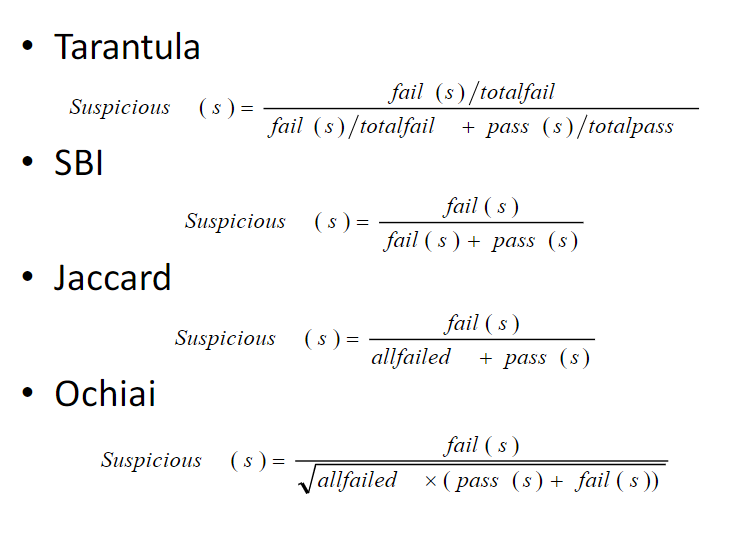

## SBFL Suspicion functions

In [36]:
import math

#Tarantula
def tarantula(times_failed, num_total_fail, times_passed, num_total_pass):
    numerator = times_failed / num_total_fail
    denominator = numerator + (times_passed / num_total_pass)
    suspicion = numerator / denominator
    return suspicion

#sbi
def sbi(times_failed, times_passed):
    suspicion = times_failed / (times_failed + times_passed)
    return suspicion

#Jaccard
def jaccard(times_failed, times_passed, total_failed):
    suspicion = times_failed / (total_failed + times_passed)
    return suspicion

#Ochiai
def ochiai(times_failed, times_passed, total_failed):
    numerator = times_failed
    denominator = math.sqrt((total_failed *(times_passed + times_failed)))
    suspicion = numerator / denominator
    return suspicion

In [37]:
from os import listdir
from os.path import isfile, join
from pathlib import Path
import random
import datetime

def get_file_list(relative_path="CoverageData"):
    """Get a list of filenames contained within the relative path provided"""
    mypath = Path(relative_path)
    onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
    return onlyfiles

def read_file(filepath):
    """Read the Contents of the file indicated by the provided Path object"""
    f = open(filepath, "r")
    content = f.read()
    return content

def write_file(filepath, content):
    """Read the Contents of the file indicated by the provided Path object"""
    f = open(filepath, "w")
    f.write(content)
    f.close()
    return

def extract_test_name(file_contents):
    """Extract the test name from the first method of a coverage data file"""
    first_method = file_contents.split("\n")[0]
    test_name = first_method.split(" ")[0]
    return test_name

def get_tested_methods(file_contents):
    """Extract the methods tested from the contents of a file"""
    tested_methods = file_contents.split("\n")[1:-1]
    return tested_methods

def test_passed(file_contents):
    """Extract the test name from the first method of a coverage data file"""
    first_method = file_contents.split("\n")[0]
    passfail = first_method.split(" ")[1]
    if passfail == "true":
        return True
    else:
        return False

def total_tests_passed(file_list, folder_name="CoverageData"): 
    """find the total number of passing tests given a list of file paths"""  
    total_passed = 0
    for file in file_list:
        file_contents = read_file(join(folder_name, file))
        if(test_passed(file_contents)):
            total_passed += 1
    return total_passed

def total_tests_failed(file_list): 
    """find the total number of failing tests given a list of file paths"""  
    total_passed = total_tests_passed(file_list)
    total_failed = len(file_list) - total_passed
    return total_failed

"""
Basically need to create a dictionary of all of the methods in all of the tests
dict
{"method1_name": [num_passed, num_failed],
 "method2_name": [num_passed, num_failed],
 ....
}

In order to create this data structure and update it, need to:
1. Go file by file and determine if the test passed, set a flag
2. Extract the tested methods from the test file
3. For each tested method, check if the method already exists in the dict
    if it doesn't, add the method dict entry with a [0, 0]
4. Update the [num_passed, num_failed] based on the passing flag
"""

def make_method_dict(file_list, folder_name="CoverageData"):
    method_dict = {}
    pass_index = 0
    fail_index = 1

    for file in file_list:
        file_contents = read_file(join(folder_name, file))
        test_methods = get_tested_methods(file_contents)
        pass_flag = test_passed(file_contents)
        for method in test_methods:
            if method not in method_dict:
                method_dict[method] = [0, 0]
            if pass_flag:
                method_dict[method][pass_index] +=1
            else:
                method_dict[method][fail_index] +=1
    
    return method_dict


"""
Need to be able to randomly select X number of tests to set to fail
1. Find a way to pick X random files from a directory
2. For each of those files, read the contents and replace "true" with "false"
3. Do the suspicion calculations
4. for every file in CoverageData, replace false with true
5. Dump the falsified tests and suspicion calculations in txt file
"""


def falsify_tests(file_list, num_tests):
    selected_tests = random.sample(file_list, num_tests)
    for test in selected_tests:
        make_test_false(test)
    return selected_tests

def make_test_false(file_name):
    content = read_file(join("CoverageData", file_name))
    false_content = content.replace("true", "false")
    write_file(join("CoverageData", file_name), false_content)
    return

def revert_false_tests(file_list):
    for file in file_list:
        make_test_true(file)
    return

def make_test_true(file_name):
    content = read_file(join("CoverageData", file_name))
    true_content = content.replace("false", "true")
    write_file(join("CoverageData", file_name), true_content)
    return

def create_sus_report(false_tests):
    report_name = datetime.datetime.now() + ".txt"
    f = open(join("suspicion_reports", report_name))
    f.write("Tests that were falsified:")
    f.write('\n'.join(false_tests))
    f.write("\n")
    f.write("Suspicion Scores")
    
    return


"""
Need to be able to calculate the suspicion scores for each method and save them in a data structure
1. find the total number of passing and failing tests
2. create a data structure as follows: {methodname: [tarantula, sbi, jaccard, ochiai]}
3. for each method in the method_dict, calculate the 4 suspicion scores and assign them to the data dict
"""

def calculate_sus(method_dict, file_list):
    sus_scores = {}

    pass_index = 0
    fail_index = 1
    
    total_pass = total_tests_passed(file_list)
    total_fail = total_tests_failed(file_list)

    for method in method_dict:
        times_passed = method_dict[method][pass_index]
        times_failed = method_dict[method][fail_index]

        tarantula_sus = tarantula(times_failed, total_fail, times_passed, total_pass)
        sbi_sus = sbi(times_failed, times_passed)
        jaccard_sus = jaccard(times_failed, times_passed, total_fail)
        ochiai_sus = ochiai(times_failed, times_passed, total_fail)

        sus_scores[method] = [tarantula_sus, sbi_sus, jaccard_sus, ochiai_sus]
        
    return sus_scores

In [38]:
file_list = get_file_list()

#falsifying X random tests
false_tests = falsify_tests(file_list, 100)

#find the total number of tests that pass and fail
total_pass = total_tests_passed(file_list)
total_fail = total_tests_failed(file_list)
print("Total number of passing tests: " + str(total_pass))
print("Total number of failing tests: " + str(total_fail))

#Make dictionary of methods and the # of times they pass and fail
method_dict = make_method_dict(file_list)

#Calculate suspicion values of tested methods
sus_data = calculate_sus(method_dict, file_list)
print(sus_data)

#Revert false tests
revert_false_tests(file_list)

"""
For each method, collect the appropriate information and run the 4 SBFL calculations:
1. Set total pass and total fail for all methods
2. Create data structure/structures to contain all 4 Suspicion scores for each method 
    Dictionary =   {"method name": suspicion_score,
                    "method name": suspicion_score,
                    ...
                    }
3. Figure out how to sort the data structure with highest scores at the front
4. Save sorted data structure to .txt file
"""

Total number of passing tests: 2162
Total number of failing tests: 100
{'org/jfree/data/general/DatasetChangeEvent:<init>:(Ljava/lang/Object;Lorg/jfree/data/general/Dataset;)V': [0.45235885959645583, 0.0368, 0.03276353276353276, 0.092], 'org/jfree/data/time/RegularTimePeriod:<init>:()V': [0.49727278701452327, 0.04375, 0.034482758620689655, 0.07826237921249264], 'org/jfree/data/general/Series:<init>:(Ljava/lang/Comparable;)V': [0.4134897360703812, 0.031578947368421054, 0.02564102564102564, 0.06155870112510924], 'org/jfree/data/general/Series:<init>:(Ljava/lang/Comparable;Ljava/lang/String;)V': [0.4134897360703812, 0.031578947368421054, 0.02564102564102564, 0.06155870112510924], 'org/jfree/data/general/Series:getKey:()Ljava/lang/Comparable;': [0.4469712631796568, 0.036036036036036036, 0.025477707006369428, 0.05369248441712195], 'org/jfree/data/general/Series:addChangeListener:(Lorg/jfree/data/general/SeriesChangeListener;)V': [0.33353903116322126, 0.02262443438914027, 0.01582278481012658

'\nFor each method, collect the appropriate information and run the 4 SBFL calculations:\n1. Set total pass and total fail for all methods\n2. Create data structure/structures to contain all 4 Suspicion scores for each method \n    Dictionary =   {"method name": suspicion_score,\n                    "method name": suspicion_score,\n                    ...\n                    }\n3. Figure out how to sort the data structure with highest scores at the front\n4. Save sorted data structure to .txt file\n'